In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def generate_cigar_data(n_samples=1000):
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)
    X[:, 0] *= 100.0
    X[:, 1] *= 0.01
    theta = np.radians(30)
    R = np.array([[np.cos(theta), -np.sin(theta)], 
                  [np.sin(theta), np.cos(theta)]])
    X = X @ R
    true_w = np.array([1.5, -2.0])
    y = X @ true_w + np.random.normal(0, 1, n_samples)
    return X, y

X, y = generate_cigar_data(1000)

In [3]:
def mse_loss(X, y, w):
    pred = X @ w
    return np.mean((y - pred) ** 2)

In [4]:
def mse_grad(X, y, w):
    n = len(y)
    pred = X @ w
    return (2/n) * X.T @ (pred - y)

In [5]:
def logcosh_loss(X, y, w):
    pred = X @ w
    return np.mean(np.log(np.cosh(y - pred)))

In [6]:
def logcosh_grad(X, y, w):
    n = len(y)
    pred = X @ w
    return -(1/n) * X.T @ np.tanh(y - pred)

In [7]:
def sigmoid(z):
    return np.where(z >= 0, 
                   1/(1 + np.exp(-z)), 
                   np.exp(z)/(1 + np.exp(z)))

In [8]:
def focal_loss(X, y, w, gamma=2.0):
    z = X @ w
    p = sigmoid(z)
    eps = 1e-7
    p = np.clip(p, eps, 1-eps)
    y_n = (y - y.min()) / (y.max() - y.min() + eps)
    return -np.mean(y_n * (1-p)**gamma * np.log(p) + 
                   (1-y_n) * p**gamma * np.log(1-p))

In [9]:
def focal_grad(X, y, w, gamma=2.0):
    n = len(y)
    z = X @ w
    p = sigmoid(z)
    eps = 1e-7
    p = np.clip(p, eps, 1-eps)
    y_n = (y - y.min()) / (y.max() - y.min() + eps)
    t1 = y_n * (1-p)**(gamma-1) * ((1-p) - gamma*p*np.log(p))
    t2 = (1-y_n) * p**(gamma-1) * (p + gamma*(1-p)*np.log(1-p))
    return (1/n) * X.T @ ((t1 - t2) * p * (1-p))

In [10]:
def batch_gd(X, y, w_init, loss_fn, grad_fn, lr=0.01, n_iter=100):
    w = w_init.copy()
    history = {'w': [w.copy()], 'loss': [], 'time': []}
    start = time.time()
    for i in range(n_iter):
        loss = loss_fn(X, y, w)
        history['loss'].append(loss)
        history['time'].append(time.time() - start)
        grad = grad_fn(X, y, w)
        w = w - lr * grad
        history['w'].append(w.copy())
    return w, history

In [11]:
def sgd(X, y, w_init, loss_fn, grad_fn, lr=0.01, n_iter=100):
    w = w_init.copy()
    history = {'w': [w.copy()], 'loss': [], 'time': []}
    n = len(y)
    start = time.time()
    for i in range(n_iter):
        loss = loss_fn(X, y, w)
        history['loss'].append(loss)
        history['time'].append(time.time() - start)
        idx = np.random.randint(0, n)
        grad = grad_fn(X[idx:idx+1], y[idx:idx+1], w)
        w = w - lr * grad
        history['w'].append(w.copy())
    return w, history

In [12]:
def mini_batch_gd(X, y, w_init, loss_fn, grad_fn, lr=0.01, n_iter=100, bs=32):
    w = w_init.copy()
    history = {'w': [w.copy()], 'loss': [], 'time': []}
    n = len(y)
    start = time.time()
    for i in range(n_iter):
        loss = loss_fn(X, y, w)
        history['loss'].append(loss)
        history['time'].append(time.time() - start)
        idx = np.random.choice(n, bs, replace=False)
        grad = grad_fn(X[idx], y[idx], w)
        w = w - lr * grad
        history['w'].append(w.copy())
    return w, history

In [13]:
w_init = np.array([0.0, 0.0])
lr = 0.0001
n_iter = 200

w_bgd, h_bgd = batch_gd(X, y, w_init, mse_loss, mse_grad, lr, n_iter)
w_sgd, h_sgd = sgd(X, y, w_init, mse_loss, mse_grad, lr, n_iter)
w_mbgd, h_mbgd = mini_batch_gd(X, y, w_init, mse_loss, mse_grad, lr, n_iter)

print("BGD:", w_bgd, "Loss:", h_bgd['loss'][-1])
print("SGD:", w_sgd, "Loss:", h_sgd['loss'][-1])
print("MBGD:", w_mbgd, "Loss:", h_mbgd['loss'][-1])

BGD: [ 1.9912695  -1.14965512] Loss: 0.9652720232327829
SGD: [ 91.23003837 153.20683663] Loss: 231.76041943355557
MBGD: [ 1.98474055 -1.14614165] Loss: 0.9900259864705878


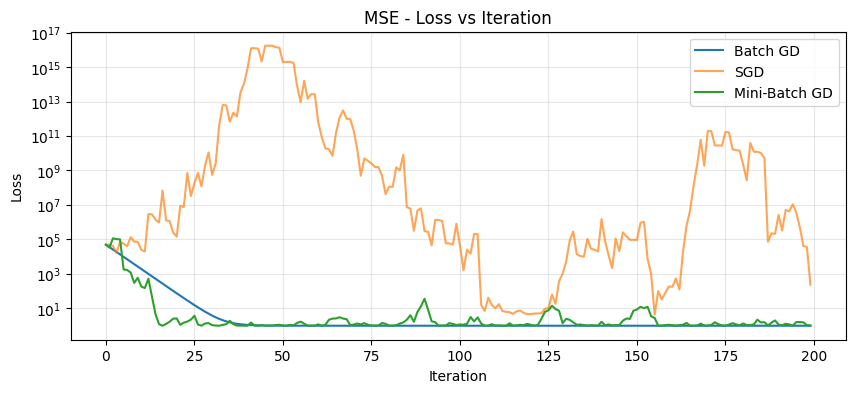

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(h_bgd['loss'], label='Batch GD')
plt.plot(h_sgd['loss'], label='SGD', alpha=0.7)
plt.plot(h_mbgd['loss'], label='Mini-Batch GD')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MSE - Loss vs Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

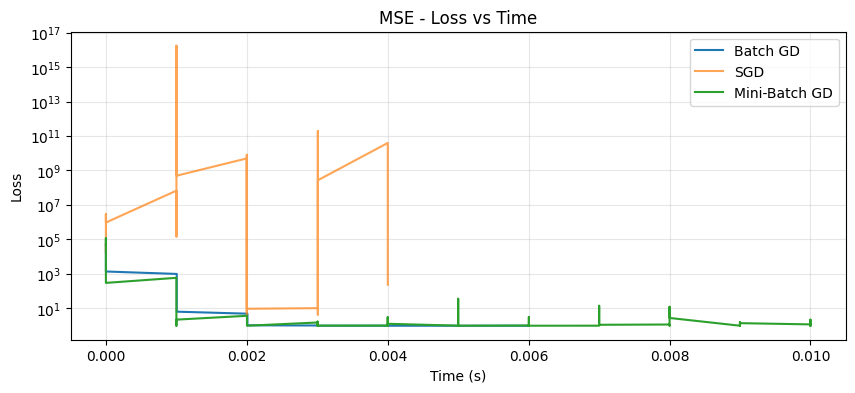

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(h_bgd['time'], h_bgd['loss'], label='Batch GD')
plt.plot(h_sgd['time'], h_sgd['loss'], label='SGD', alpha=0.7)
plt.plot(h_mbgd['time'], h_mbgd['loss'], label='Mini-Batch GD')
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.title('MSE - Loss vs Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

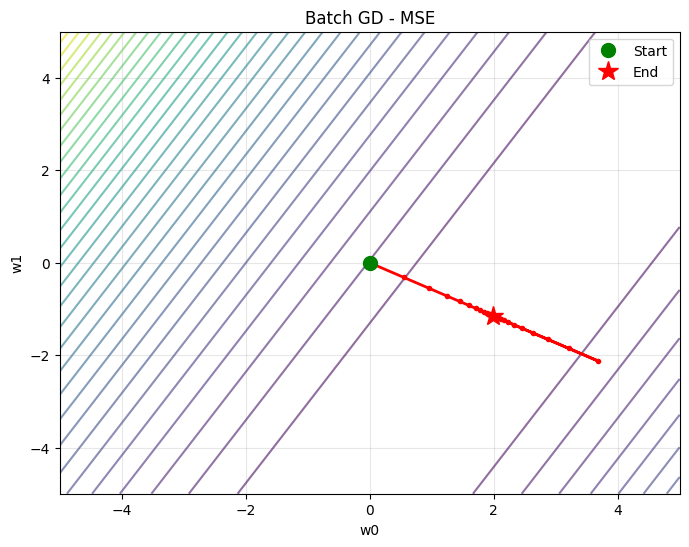

In [16]:
w0_range = np.linspace(-5, 5, 100)
w1_range = np.linspace(-5, 5, 100)
W0, W1 = np.meshgrid(w0_range, w1_range)
Z = np.zeros_like(W0)

for i in range(len(w0_range)):
    for j in range(len(w1_range)):
        w = np.array([W0[i, j], W1[i, j]])
        Z[i, j] = mse_loss(X, y, w)

plt.figure(figsize=(8, 6))
plt.contour(W0, W1, Z, levels=30, cmap='viridis', alpha=0.6)
weights = np.array(h_bgd['w'])
plt.plot(weights[:, 0], weights[:, 1], 'r.-', linewidth=2)
plt.plot(weights[0, 0], weights[0, 1], 'go', markersize=10, label='Start')
plt.plot(weights[-1, 0], weights[-1, 1], 'r*', markersize=15, label='End')
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('Batch GD - MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

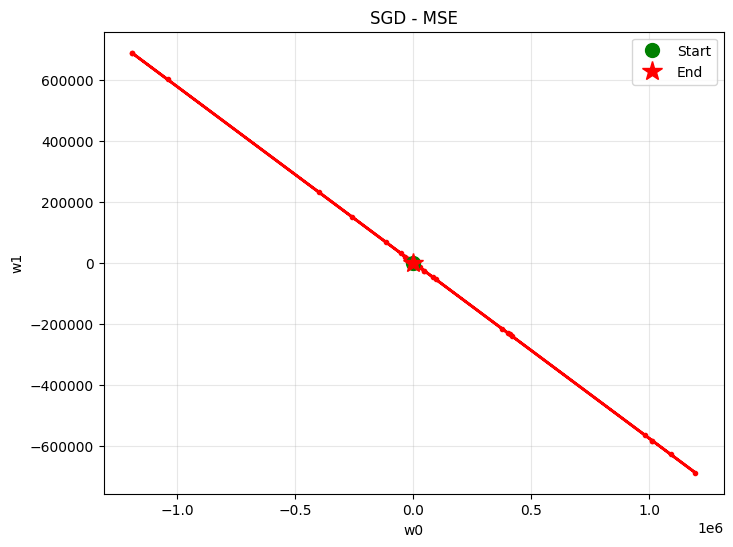

In [17]:
plt.figure(figsize=(8, 6))
plt.contour(W0, W1, Z, levels=30, cmap='viridis', alpha=0.6)
weights = np.array(h_sgd['w'])
plt.plot(weights[:, 0], weights[:, 1], 'r.-', linewidth=2)
plt.plot(weights[0, 0], weights[0, 1], 'go', markersize=10, label='Start')
plt.plot(weights[-1, 0], weights[-1, 1], 'r*', markersize=15, label='End')
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('SGD - MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

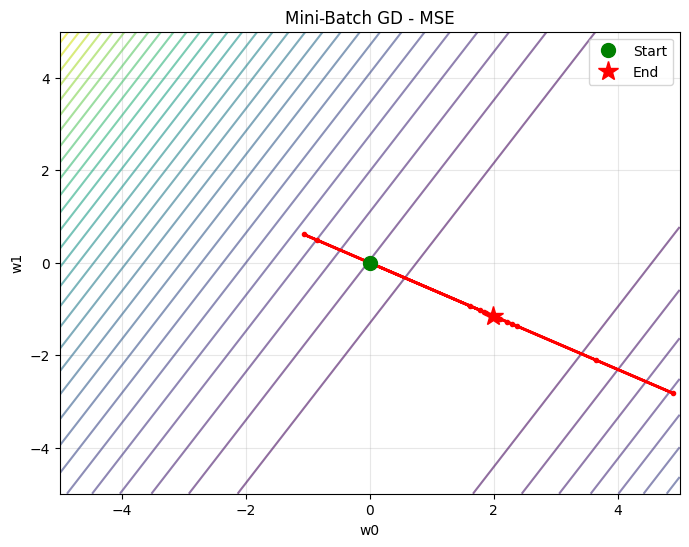

In [18]:
plt.figure(figsize=(8, 6))
plt.contour(W0, W1, Z, levels=30, cmap='viridis', alpha=0.6)
weights = np.array(h_mbgd['w'])
plt.plot(weights[:, 0], weights[:, 1], 'r.-', linewidth=2)
plt.plot(weights[0, 0], weights[0, 1], 'go', markersize=10, label='Start')
plt.plot(weights[-1, 0], weights[-1, 1], 'r*', markersize=15, label='End')
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('Mini-Batch GD - MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
lr_lc = 0.001

w_bgd_lc, h_bgd_lc = batch_gd(X, y, w_init, logcosh_loss, logcosh_grad, lr_lc, n_iter)
w_sgd_lc, h_sgd_lc = sgd(X, y, w_init, logcosh_loss, logcosh_grad, lr_lc, n_iter)
w_mbgd_lc, h_mbgd_lc = mini_batch_gd(X, y, w_init, logcosh_loss, logcosh_grad, lr_lc, n_iter)

print("BGD:", w_bgd_lc, "Loss:", h_bgd_lc['loss'][-1])
print("SGD:", w_sgd_lc, "Loss:", h_sgd_lc['loss'][-1])
print("MBGD:", w_mbgd_lc, "Loss:", h_mbgd_lc['loss'][-1])

BGD: [ 1.95991943 -1.13156257] Loss: 2.1444609716303904
SGD: [ 1.96095722 -1.13209462] Loss: 1.4555974338331714
MBGD: [ 1.94796748 -1.12465667] Loss: 1.3462292886898564


C:\Users\VASU MONPARA\AppData\Local\Temp\ipykernel_21568\119443355.py:3: RuntimeWarning: overflow encountered in cosh
  return np.mean(np.log(np.cosh(y - pred)))


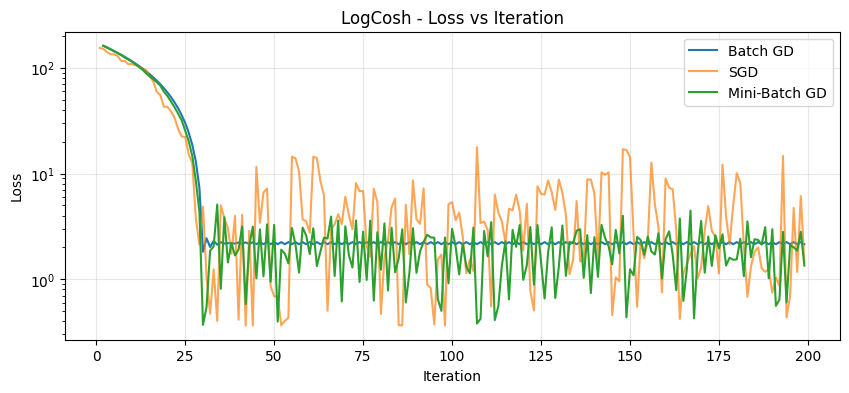

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(h_bgd_lc['loss'], label='Batch GD')
plt.plot(h_sgd_lc['loss'], label='SGD', alpha=0.7)
plt.plot(h_mbgd_lc['loss'], label='Mini-Batch GD')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('LogCosh - Loss vs Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

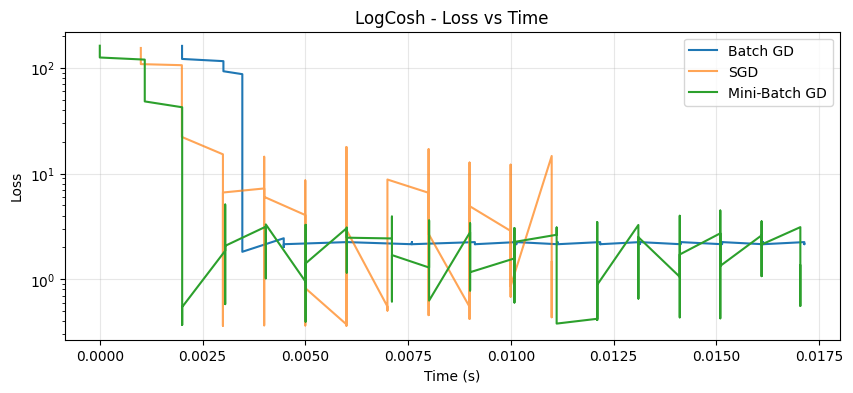

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(h_bgd_lc['time'], h_bgd_lc['loss'], label='Batch GD')
plt.plot(h_sgd_lc['time'], h_sgd_lc['loss'], label='SGD', alpha=0.7)
plt.plot(h_mbgd_lc['time'], h_mbgd_lc['loss'], label='Mini-Batch GD')
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.title('LogCosh - Loss vs Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
lr_f = 0.01

w_bgd_f, h_bgd_f = batch_gd(X, y, w_init, focal_loss, focal_grad, lr_f, n_iter)
w_sgd_f, h_sgd_f = sgd(X, y, w_init, focal_loss, focal_grad, lr_f, n_iter)
w_mbgd_f, h_mbgd_f = mini_batch_gd(X, y, w_init, focal_loss, focal_grad, lr_f, n_iter)

print("BGD:", w_bgd_f, "Loss:", h_bgd_f['loss'][-1])
print("SGD:", w_sgd_f, "Loss:", h_sgd_f['loss'][-1])
print("MBGD:", w_mbgd_f, "Loss:", h_mbgd_f['loss'][-1])

BGD: [-0.21076495  0.12168646] Loss: 7.577108831942958
SGD: [-0.17150235  0.09899098] Loss: 7.069484647326151
MBGD: [-0.21215253  0.12249387] Loss: 7.589059699030369


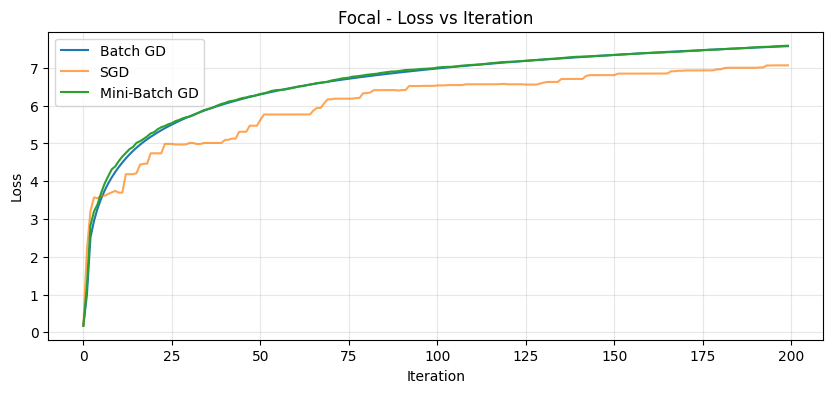

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(h_bgd_f['loss'], label='Batch GD')
plt.plot(h_sgd_f['loss'], label='SGD', alpha=0.7)
plt.plot(h_mbgd_f['loss'], label='Mini-Batch GD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Focal - Loss vs Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

diabetes = load_diabetes()
X_d = diabetes.data[:, :2]
y_d = diabetes.target

scaler = StandardScaler()
X_d = scaler.fit_transform(X_d)

print("Diabetes shape:", X_d.shape, y_d.shape)

Diabetes shape: (442, 2) (442,)


In [25]:
w_bgd_d, h_bgd_d = batch_gd(X_d, y_d, w_init, mse_loss, mse_grad, 0.01, n_iter)
w_sgd_d, h_sgd_d = sgd(X_d, y_d, w_init, mse_loss, mse_grad, 0.01, n_iter)
w_mbgd_d, h_mbgd_d = mini_batch_gd(X_d, y_d, w_init, mse_loss, mse_grad, 0.01, n_iter)

print("BGD:", w_bgd_d, "Loss:", h_bgd_d['loss'][-1])
print("SGD:", w_sgd_d, "Loss:", h_sgd_d['loss'][-1])
print("MBGD:", w_mbgd_d, "Loss:", h_mbgd_d['loss'][-1])

BGD: [14.01838459  1.00270637] Loss: 28864.590015286085
SGD: [19.57942924 14.0652015 ] Loss: 29125.092719895838
MBGD: [12.78208389  2.68804216] Loss: 28871.881885668365


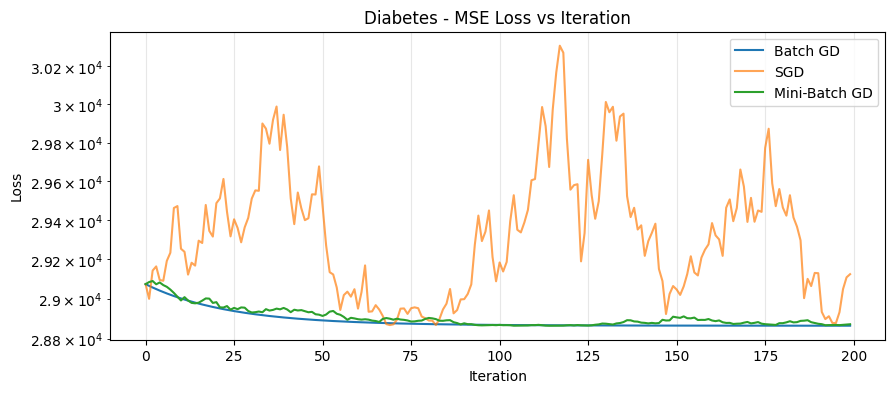

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(h_bgd_d['loss'], label='Batch GD')
plt.plot(h_sgd_d['loss'], label='SGD', alpha=0.7)
plt.plot(h_mbgd_d['loss'], label='Mini-Batch GD')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Diabetes - MSE Loss vs Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X_h = housing.data[:1000, :2]
y_h = housing.target[:1000]

scaler_h = StandardScaler()
X_h = scaler_h.fit_transform(X_h)

print("Housing shape:", X_h.shape, y_h.shape)

Housing shape: (1000, 2) (1000,)


In [28]:
w_bgd_h, h_bgd_h = batch_gd(X_h, y_h, w_init, mse_loss, mse_grad, 0.01, n_iter)
w_sgd_h, h_sgd_h = sgd(X_h, y_h, w_init, mse_loss, mse_grad, 0.01, n_iter)
w_mbgd_h, h_mbgd_h = mini_batch_gd(X_h, y_h, w_init, mse_loss, mse_grad, 0.01, n_iter)

print("BGD:", w_bgd_h, "Loss:", h_bgd_h['loss'][-1])
print("SGD:", w_sgd_h, "Loss:", h_sgd_h['loss'][-1])
print("MBGD:", w_mbgd_h, "Loss:", h_mbgd_h['loss'][-1])

BGD: [0.67750198 0.04583704] Loss: 4.713183195559465
SGD: [ 0.35428768 -0.17409017] Loss: 4.840655215131947
MBGD: [ 0.66961279 -0.0109511 ] Loss: 4.719466666405713


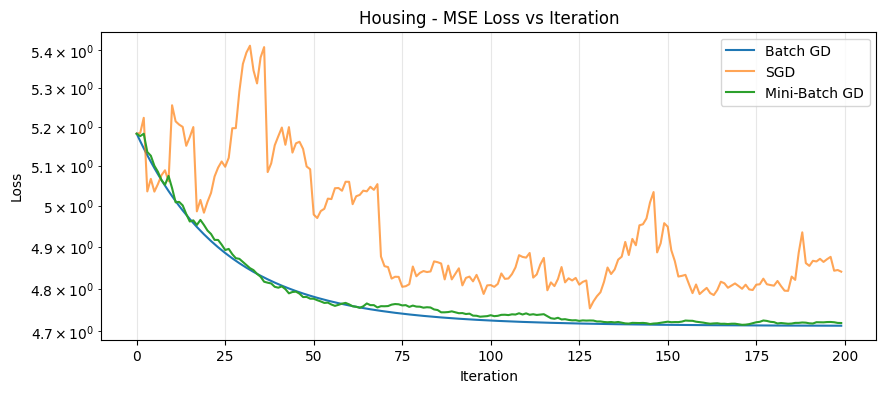

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(h_bgd_h['loss'], label='Batch GD')
plt.plot(h_sgd_h['loss'], label='SGD', alpha=0.7)
plt.plot(h_mbgd_h['loss'], label='Mini-Batch GD')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Housing - MSE Loss vs Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
print("="*60)
print("FINAL COMPARISON")
print("="*60)
print(f"Cigar MSE    - BGD: {h_bgd['loss'][-1]:.4f}, SGD: {h_sgd['loss'][-1]:.4f}, MBGD: {h_mbgd['loss'][-1]:.4f}")
print(f"Cigar LogCosh- BGD: {h_bgd_lc['loss'][-1]:.4f}, SGD: {h_sgd_lc['loss'][-1]:.4f}, MBGD: {h_mbgd_lc['loss'][-1]:.4f}")
print(f"Cigar Focal  - BGD: {h_bgd_f['loss'][-1]:.4f}, SGD: {h_sgd_f['loss'][-1]:.4f}, MBGD: {h_mbgd_f['loss'][-1]:.4f}")
print(f"Diabetes MSE - BGD: {h_bgd_d['loss'][-1]:.4f}, SGD: {h_sgd_d['loss'][-1]:.4f}, MBGD: {h_mbgd_d['loss'][-1]:.4f}")
print(f"Housing MSE  - BGD: {h_bgd_h['loss'][-1]:.4f}, SGD: {h_sgd_h['loss'][-1]:.4f}, MBGD: {h_mbgd_h['loss'][-1]:.4f}")
print("="*60)

FINAL COMPARISON
Cigar MSE    - BGD: 0.9653, SGD: 231.7604, MBGD: 0.9900
Cigar LogCosh- BGD: 2.1445, SGD: 1.4556, MBGD: 1.3462
Cigar Focal  - BGD: 7.5771, SGD: 7.0695, MBGD: 7.5891
Diabetes MSE - BGD: 28864.5900, SGD: 29125.0927, MBGD: 28871.8819
Housing MSE  - BGD: 4.7132, SGD: 4.8407, MBGD: 4.7195
